# Tiny sign language interpreter


**Acknowledgements**

Dataset https://www.kaggle.com/code/paultimothymooney/interpret-sign-language-with-deep-learning/notebook

Introduction and inspiration https://www.edx.org/certificates/professional-certificate/harvardx-tiny-machine-learning


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import tensorflow as tf
import pathlib


from tensorflow.keras.preprocessing import image_dataset_from_directory

## Build the dataset

### Download the dataset
> Training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.

Data has to be ogranized into train, validation and test splits(original validation set is very small).

Set access to kaggle

In [ ]:
# https://www.kaggle.com/discussions/general/74235

from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grassknoted/asl-alphabet

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 98% 1.01G/1.03G [00:11<00:00, 124MB/s]
100% 1.03G/1.03G [00:11<00:00, 93.4MB/s]


In [ ]:
! rm -rf asl_alphabet_test/
! unzip -o asl-alphabet.zip > /dev/null

In [ ]:
! mv asl_alphabet_test/asl_alphabet_test/ asl_alphabet_test/asl_alphabet_test_2/
! rm -rf asl_alphabet_test/asl_alphabet_test/
! rm -rf asl_alphabet_test/asl_alphabet_validation/

In [ ]:
train_dir = "/content/asl_alphabet_train/asl_alphabet_train/"
valid_dir = "/content/asl_alphabet_train/asl_alphabet_validation/"
test_dir =  "/content/asl_alphabet_test/asl_alphabet_test/"

SEED = 123
random.seed(SEED)

# for each label move ~10% to test directory
for label in os.listdir(train_dir):
    src = os.path.join(train_dir, label)
    subset_size = len(os.listdir(src)) // 10
    for work_dir in [valid_dir, test_dir]:
        dst = os.path.join(work_dir, label)
        files = os.listdir(src)
        if not os.path.exists(dst):
            os.makedirs(dst)

        for file_name in random.sample(files, subset_size):
            if not os.path.exists(os.path.join(dst, file_name)):
                shutil.move(os.path.join(src, file_name), dst)


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode='categorical',
                                             color_mode='grayscale',
                                             seed=SEED,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

valid_dataset = image_dataset_from_directory(valid_dir,
                                             label_mode='categorical',
                                             color_mode='grayscale',
                                             seed=SEED,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            label_mode='categorical',
                                            color_mode='grayscale',
                                            seed=SEED,
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 69600 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.


Now that we have built the dataset lets view the first nine images and labels from the training set:

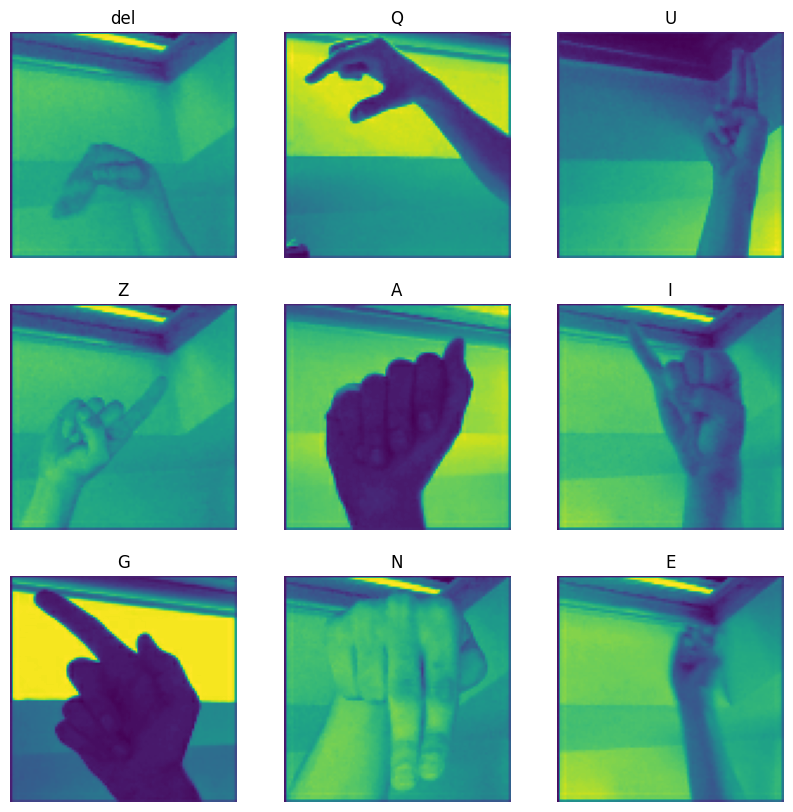

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation((-0.05, 0.05)),
  tf.keras.layers.RandomZoom((-0.1, 0.1)),
  tf.keras.layers.RandomContrast((0.1, 0.1)),
  tf.keras.layers.RandomBrightness((-0.1, 0.1)),
])

In [ ]:
train_dataset = train_dataset.map(
  lambda x, y: (data_augmentation(x, training=True), y))

### Preprocess input

MobileNet expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

## Build the Model

### Create the base model
You will create the base model from the **MobileNet V1** model configured for 29 classes. To make it better fit for TinyML model is scaled down with alpha parameter

In [ ]:
IMG_SHAPE = IMG_SIZE + (1,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             alpha=0.25,
                                             weights=None)

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenet_0.25_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 8)         72        
                                                                 
 conv1_bn (BatchNormalizati  (None, 48, 48, 8)         32        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 48, 48, 8)         72        
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 48, 48, 8)   

### Custom classification layers

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(29, activation='softmax', )

### Combine base model and other parts into final model

In [ ]:
inputs = tf.keras.Input(shape=(96, 96, 1))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile model

In [ ]:
base_learning_rate = 0.00045
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 96, 96, 1)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 96, 96, 1)         0         
 mbda)                                                           
                                                                 
 mobilenet_0.25_96 (Functio  (None, 3, 3, 256)         218400    
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 256)               0         
 GlobalAveragePooling2D)                                   

### Train the model

In [ ]:
epochs_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.dirname("epochs/cp.ckpt"),
                                                      save_weights_only=True,
                                                      verbose=1,
                                                      save_freq=int(25*train_dataset.cardinality().numpy()))
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.dirname("best/cp.ckpt"),
                                                     save_best_only=True,
                                                     verbose=1,
                                                     monitor="val_loss",
                                                     initial_value_threshold=0.1)


EPOCHS = 100
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=[epochs_checkpoint, best_checkpoint])

Epoch 1/100
2175/2175 [==============================] - ETA: 0s - loss: 1.1012 - accuracy: 0.6353
Epoch 1: val_loss did not improve from 0.10000
2175/2175 [==============================] - 111s 45ms/step - loss: 1.1012 - accuracy: 0.6353 - val_loss: 0.5053 - val_accuracy: 0.8305
Epoch 2/100
2175/2175 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.8265
Epoch 2: val_loss did not improve from 0.10000
2175/2175 [==============================] - 100s 46ms/step - loss: 0.5122 - accuracy: 0.8265 - val_loss: 0.2293 - val_accuracy: 0.9218
Epoch 3/100
2175/2175 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8931
Epoch 3: val_loss did not improve from 0.10000
2175/2175 [==============================] - 99s 46ms/step - loss: 0.3125 - accuracy: 0.8931 - val_loss: 0.1269 - val_accuracy: 0.9561
Epoch 4/100
2174/2175 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9247
Epoch 4: val_loss improved from 0.10000 to 0.08121, savi

Did you hit you accuracy goal? Did you overshoot and spend some extra time training? When might you have been able to quit? Lets take a look at the learning curves of the training and validation accuracy/loss to analyze our results.

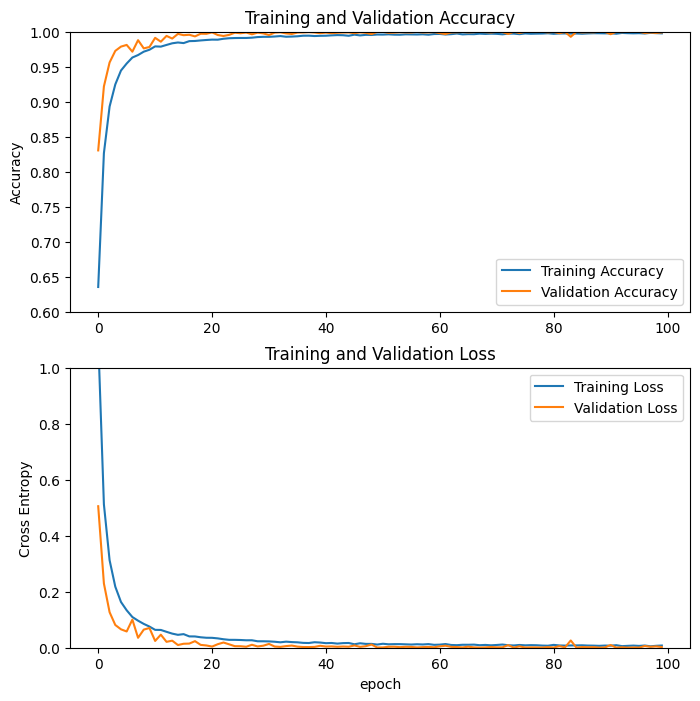

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.6,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate your model

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)
test_dataset = image_dataset_from_directory(test_dir,
                                            label_mode='categorical',
                                            color_mode='grayscale',
                                            seed=SEED,
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 8700 files belonging to 29 classes.


In [ ]:
test_data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation((-0.06, 0.06)),
  tf.keras.layers.RandomZoom((-0.2, 0.2)),
  tf.keras.layers.RandomContrast((0.2, 0.2)),
  tf.keras.layers.RandomBrightness((-0.2, 0.2)),
])

In [ ]:
test_dataset_ag = test_dataset.map(
  lambda x, y: (test_data_augmentation(x, training=True), y))

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy = model.evaluate(test_dataset_ag)
print('Test accuracy :', accuracy)

272/272 [==============================] - 4s 15ms/step - loss: 0.0024 - accuracy: 0.9990
Test accuracy : 0.9989655017852783
272/272 [==============================] - 11s 38ms/step - loss: 0.0539 - accuracy: 0.9870
Test accuracy : 0.9870114922523499


In [ ]:
import seaborn as sns
# adapted from https://www.tensorflow.org/tutorials/video/video_classification#evaluate_the_model
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)
  actual = tf.stack(actual, axis=0)
  actual = tf.argmax(actual, axis=1)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)S

  return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(48, 48)})
  sns.set(font_scale=1)
  ax.set_title('Confusion matrix for ' + ds_type)
  ax.set_xlabel('Predicted gesture')
  ax.set_ylabel('Actual gesture')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


272/272 [==============================] - 10s 37ms/step


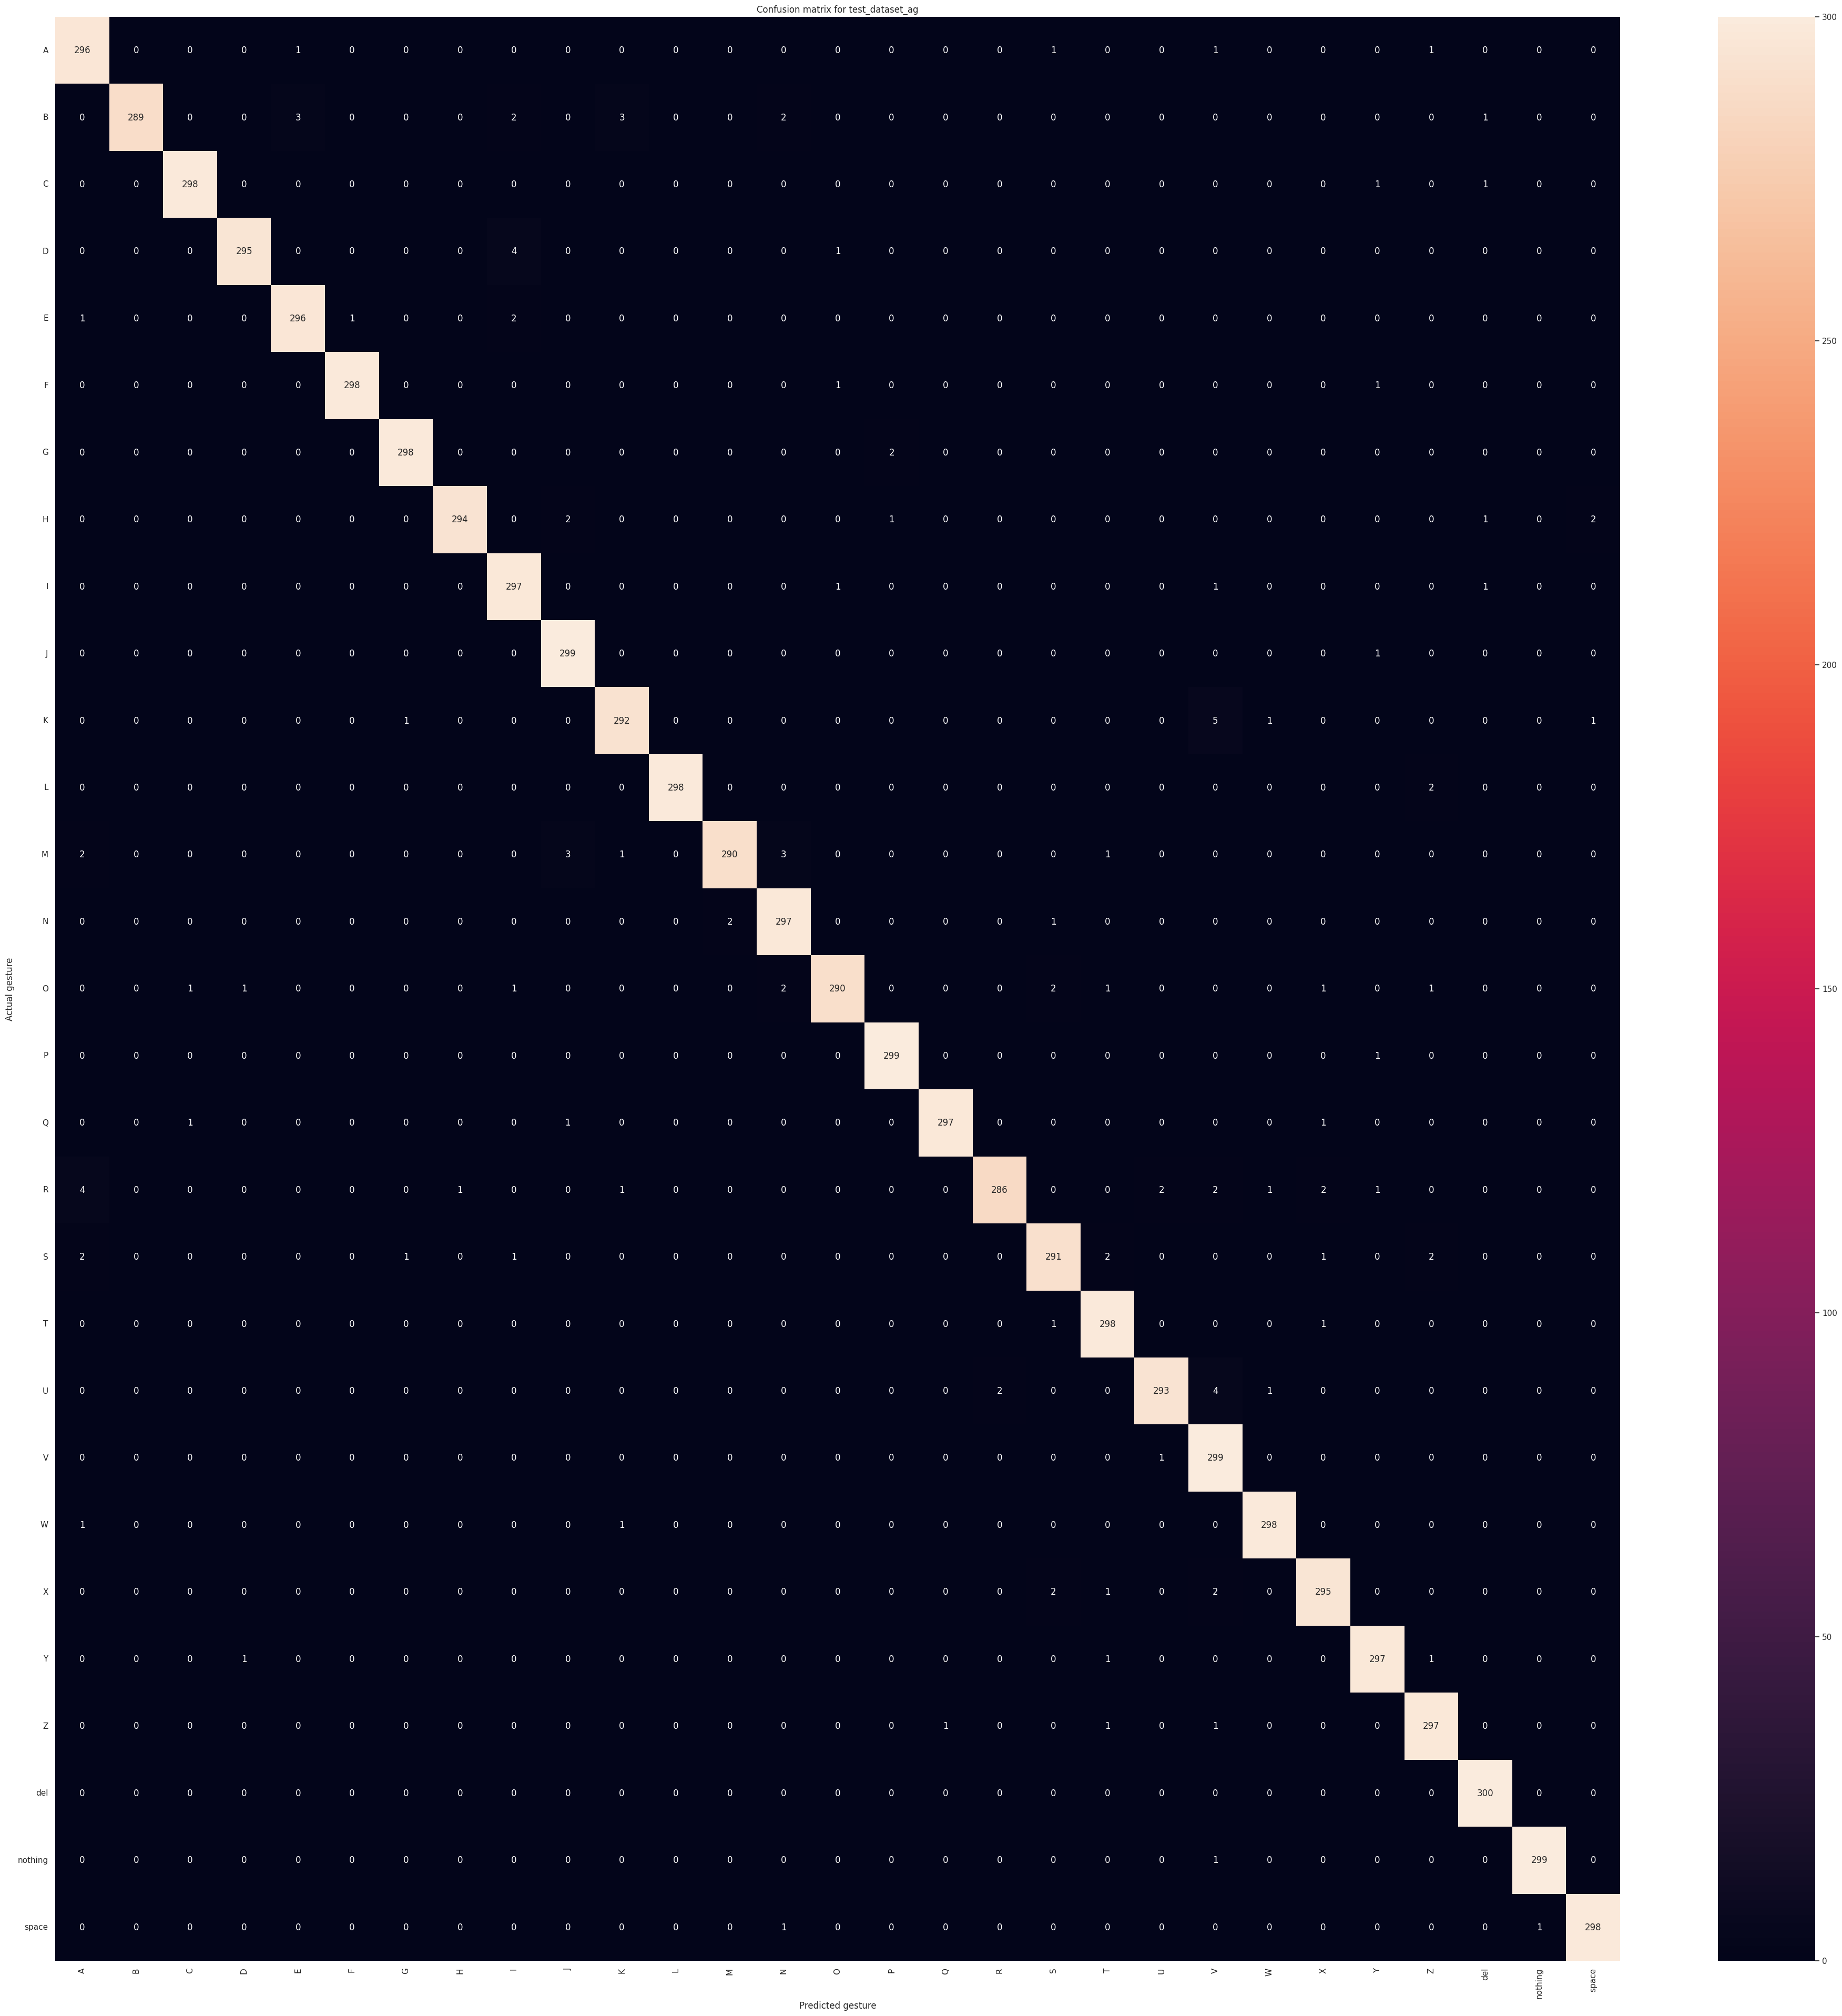

In [ ]:
actual, predicted = get_actual_predicted_labels(test_dataset_ag)
plot_confusion_matrix(actual, predicted, class_names, 'test_dataset_ag')

And assuming your model passed the accuracy threshold you are now are all set to use this model to predict if the person is wearing a mask or not. Lets print the results from a bunch of the images in our test dataset!


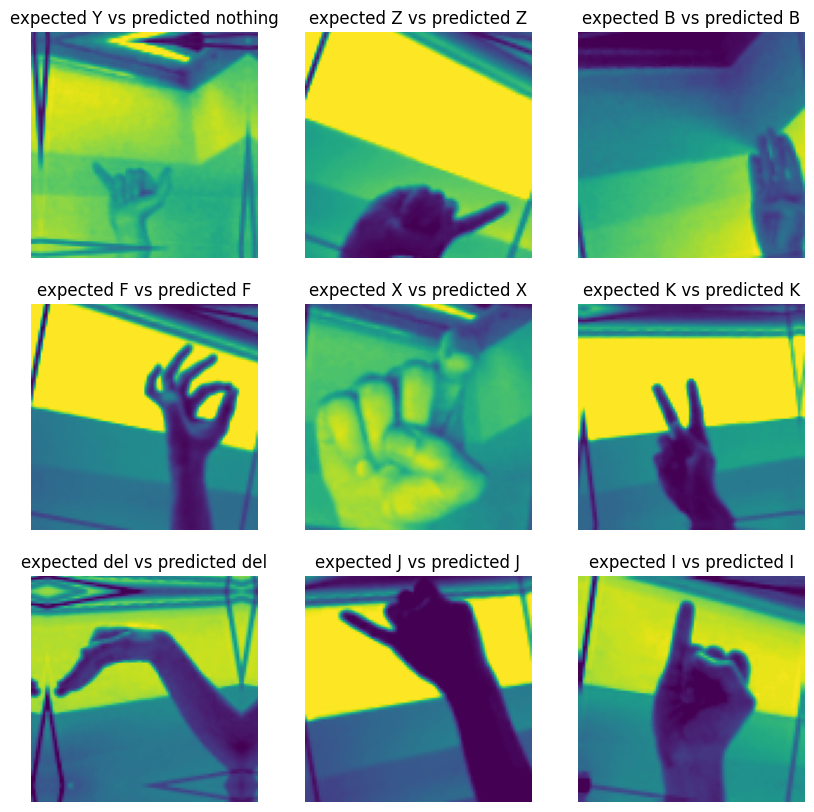

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset_ag.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"expected {class_names[label_batch[i].argmax()]} vs predicted {class_names[predictions[i].argmax()]}")
  plt.axis("off")

### Save model

In [ ]:
tf.saved_model.save(model, "sign_language_model")
model.save('sign_language_model.keras')

## Covert model


In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.lite.TFLiteConverter.from_saved_model("best")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path(".")

tflite_model_file = tflite_models_dir/'model_quant_best.tflite'
tflite_model_file.write_bytes(tflite_model)


283992

In [ ]:

def representative_data_gen():
    for input_value, _ in test_dataset.take(272):
        yield [input_value]

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.lite.TFLiteConverter.from_saved_model("best")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path(".")

tflite_model_file = tflite_models_dir/'model_quant_int8_best.tflite'
tflite_model_file.write_bytes(tflite_model)


314568

Prepare headers with model data

In [ ]:
# taken from https://medium.com/@a.ayyuced/image-classification-models-on-arduino-nano-33-ble-sense-60bf845fd2aa
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

for m in ["model_quant_int8_best", "model_quant_best"]:
  tflite_binary = open(m + ".tflite", 'rb').read()
  ascii_bytes = convert_to_c_array(tflite_binary)
  c_file = "const unsigned char tf_model[] = {\n  " + ascii_bytes + "\n};\nunsigned int tf_model_len = " + str(len(tflite_binary)) + ";"
  open(m + ".h", "w").write(c_file)

In [ ]:
!zip -r models.zip ./sign_language_model sign_language_model.keras ./best model_quant*


updating: sign_language_model/ (stored 0%)
updating: sign_language_model/saved_model.pb (deflated 91%)
updating: sign_language_model/variables/ (stored 0%)
updating: sign_language_model/variables/variables.index (deflated 77%)
updating: sign_language_model/variables/variables.data-00000-of-00001 (deflated 10%)
updating: sign_language_model/assets/ (stored 0%)
updating: sign_language_model/fingerprint.pb (stored 0%)
updating: sign_language_model.keras (deflated 18%)
updating: best/ (stored 0%)
updating: best/saved_model.pb (deflated 91%)
updating: best/variables/ (stored 0%)
updating: best/variables/variables.index (deflated 76%)
updating: best/variables/variables.data-00000-of-00001 (deflated 10%)
updating: best/assets/ (stored 0%)
updating: best/keras_metadata.pb (deflated 96%)
updating: best/fingerprint.pb (stored 0%)
updating: model_quant_int8.tflite (deflated 24%)
updating: model_quant.tflite (deflated 17%)
updating: model_quant_int8.h (deflated 79%)
updating: model_quant.h (deflat

In [ ]:
from google.colab import files
files.download("models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluate models after conversion

In [ ]:
from tqdm import tqdm
import cv2

# Load TFLite model and allocate tensors.
tflite_model_file = 'model_quant_int8_best.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels = []
for img, label in tqdm(test_dataset_ag.take(272).unbatch()):
    interpreter.set_tensor(input_index, tf.reshape(img, [1,96,96,1]))
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(np.argmax(label.numpy()))

score = 0
for item in range(len(test_labels)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Score " + str(score / len(test_labels)) + " correct")

8700it [00:22, 389.74it/s]

Score 0.988735632183908 correct
